In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
import json
import joblib

In [ ]:
small_df = pd.read_csv('/content/sample_data/Crop_recommendation.csv')

In [ ]:
small_df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [ ]:
big_df = pd.read_csv('/content/sample_data/TARP.csv')

In [ ]:
big_df.head()

,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K,Status
0,54,22,70,21,19.52,2.13,55.04,6.30,101.50,6.502985,202.935536,90.0,42.0,43.0,ON
1,12,20,40,104,19.49,2.01,55.17,10.46,101.50,7.038096,226.655537,85.0,58.0,41.0,OFF
2,34,26,35,62,19.47,1.90,55.30,14.63,101.51,7.840207,263.964248,60.0,55.0,44.0,ON
3,7,44,44,93,19.54,2.28,54.20,16.08,101.51,6.980401,242.864034,74.0,35.0,40.0,OFF
4,50,38,23,92,19.61,2.66,53.09,17.52,101.51,7.628473,262.717340,78.0,42.0,42.0,OFF


In [ ]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Soil Moisture        100000 non-null  int64  
 1   Temperature          100000 non-null  int64  
 2    Soil Humidity       100000 non-null  int64  
 3   Time                 100000 non-null  int64  
 4   Air temperature (C)  23995 non-null   float64
 5   Wind speed (Km/h)    23995 non-null   float64
 6   Air humidity (%)     23995 non-null   float64
 7   Wind gust (Km/h)     23995 non-null   float64
 8   Pressure (KPa)       23995 non-null   float64
 9   ph                   2200 non-null    float64
 10  rainfall             2200 non-null    float64
 11  N                    2200 non-null    float64
 12  P                    2200 non-null    float64
 13  K                    2200 non-null    float64
 14  Status               100000 non-null  object 
dtypes: float64(10), in

## Handle the missing values of the bid data

# Using KNNImputer Algorithm

In [ ]:
missing_cols = big_df.columns[big_df.isnull().any()]
print("Columns with missing values:", list(missing_cols))

Columns with missing values: ['Air temperature (C)', 'Wind speed (Km/h)', 'Air humidity (%)', 'Wind gust (Km/h)', 'Pressure (KPa)', 'ph', 'rainfall', 'N', 'P', 'K']


In [ ]:
sample = big_df[missing_cols].dropna()
if len(sample) > 1000:
    sample = sample.sample(1000, random_state=42)
print("Sample shape:", sample.shape)

Sample shape: (1000, 10)


In [ ]:
masked_sample = sample.copy()
mask = np.random.rand(*sample.shape) < 0.1  # Hiding 10% of the data
masked_sample[mask] = np.nan
print("Number of hidden (masked) values:", mask.sum())

Number of hidden (masked) values: 1017


In [ ]:
duplicates_ratio = big_df.duplicated().mean()
print(f"Duplicate rows ratio: {duplicates_ratio:.2%}")

Duplicate rows ratio: 0.11%


In [ ]:
errors = {}
for k in [2, 3, 5, 7, 9, 11]:
    imputer = KNNImputer(n_neighbors=k)
    imputed = imputer.fit_transform(masked_sample)

    mse = mean_squared_error(sample.values[~mask], imputed[~mask])
    errors[k] = mse
    print(f"K={k} --> MSE={mse:.5f}")

K=2 --> MSE=0.00000
K=3 --> MSE=0.00000
K=5 --> MSE=0.00000
K=7 --> MSE=0.00000
K=9 --> MSE=0.00000
K=11 --> MSE=0.00000


In [ ]:
# Make sure of the KNN worked well
mask = np.random.rand(*sample.shape) < 0.05
masked_sample = sample.copy()
masked_sample[mask] = np.nan

imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(masked_sample)

mse = mean_squared_error(sample.values[mask], imputed[mask])
print(f"MSE (more random test) = {mse}")

MSE (more random test) = 182.6233763920576


In [ ]:
best_k = min(errors, key=errors.get)
print("\n Best K value:", best_k)


 Best K value: 2


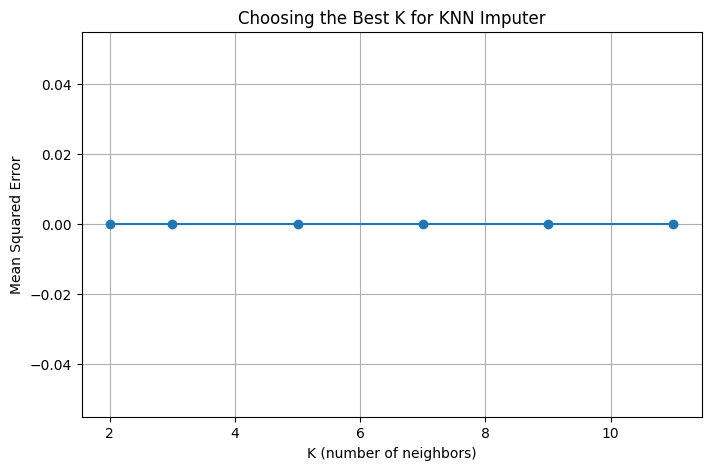

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(list(errors.keys()), list(errors.values()), marker='o')
plt.xlabel('K (number of neighbors)')
plt.ylabel('Mean Squared Error')
plt.title('Choosing the Best K for KNN Imputer')
plt.grid(True)
plt.show()

In [ ]:
numeric_columns = big_df.select_dtypes(include=[np.number]).columns
non_numeric_columns = big_df.select_dtypes(exclude=[np.number]).columns

In [ ]:
numeric_df = big_df[numeric_columns]

In [ ]:
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(numeric_df)
imputed_df = pd.DataFrame(imputed_array, columns=numeric_columns)
big_df = pd.concat([imputed_df, big_df[non_numeric_columns].reset_index(drop=True)], axis=1)

In [ ]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Soil Moisture        100000 non-null  float64
 1   Temperature          100000 non-null  float64
 2    Soil Humidity       100000 non-null  float64
 3   Time                 100000 non-null  float64
 4   Air temperature (C)  100000 non-null  float64
 5   Wind speed (Km/h)    100000 non-null  float64
 6   Air humidity (%)     100000 non-null  float64
 7   Wind gust (Km/h)     100000 non-null  float64
 8   Pressure (KPa)       100000 non-null  float64
 9   ph                   100000 non-null  float64
 10  rainfall             100000 non-null  float64
 11  N                    100000 non-null  float64
 12  P                    100000 non-null  float64
 13  K                    100000 non-null  float64
 14  Status               100000 non-null  object 
dtypes: float64(14), ob

## Detect outliers

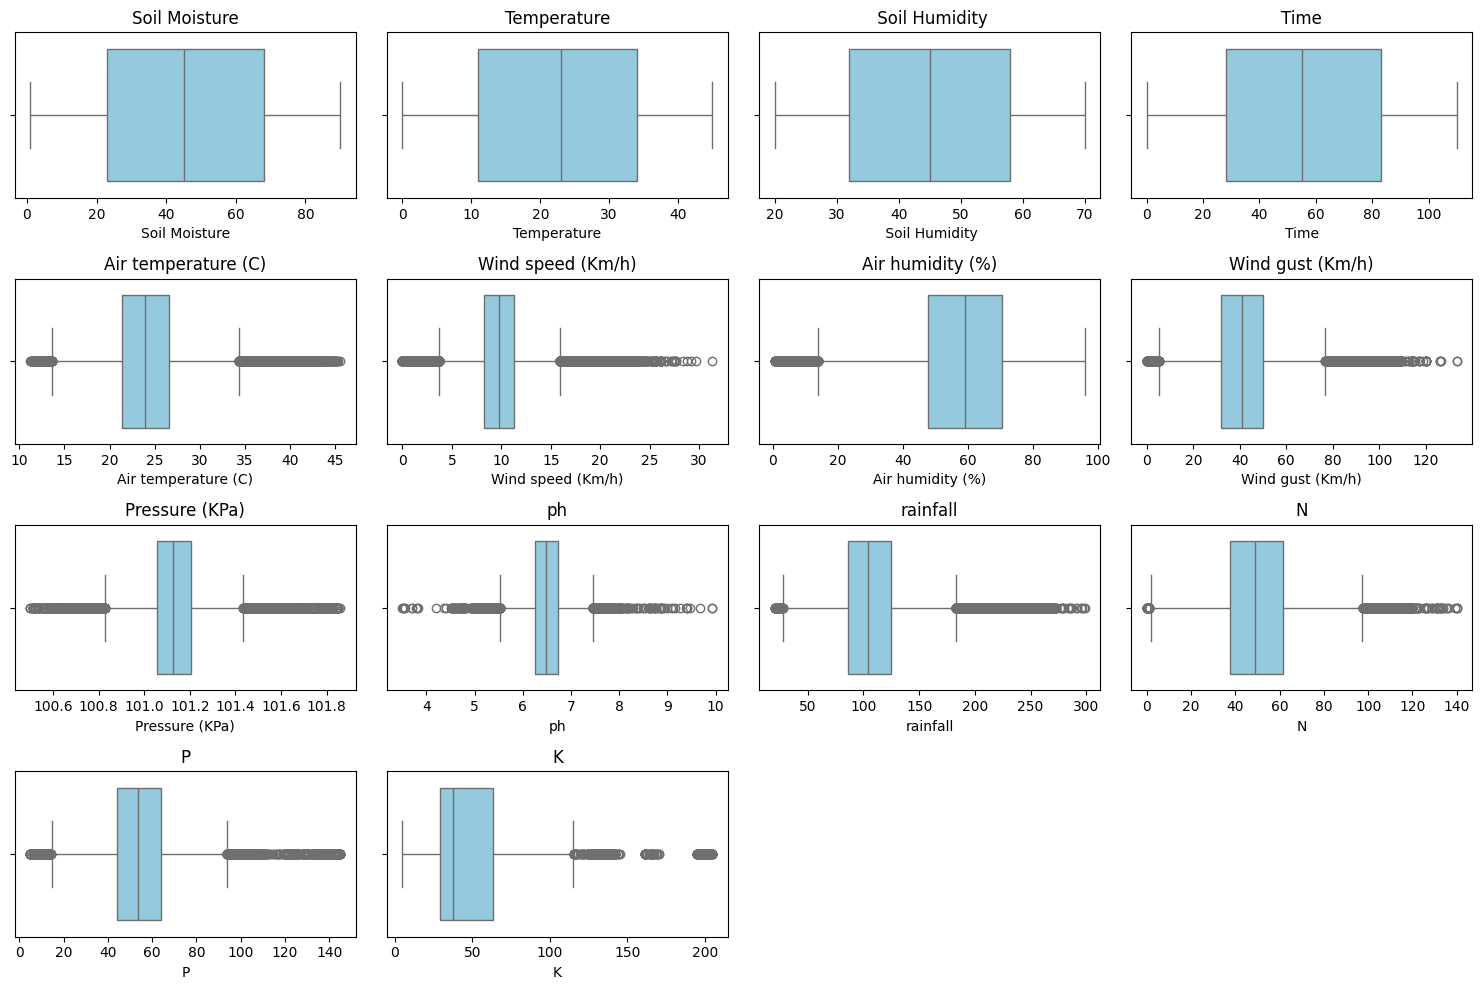

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x=big_df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
outliers_info = {}

for col in numeric_columns:
    Q1 = big_df[col].quantile(0.25)
    Q3 = big_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = big_df[(big_df[col] < lower) | (big_df[col] > upper)]
    outliers_info[col] = len(outliers)

outliers_df = pd.DataFrame(list(outliers_info.items()), columns=['Column', 'Outlier Count'])
outliers_df.sort_values(by='Outlier Count', ascending=False)

,Column,Outlier Count
5,Wind speed (Km/h),4015
8,Pressure (KPa),3783
10,rainfall,3142
7,Wind gust (Km/h),2999
6,Air humidity (%),2660
4,Air temperature (C),2638
12,P,1116
9,ph,1090
13,K,820
11,N,792


In [ ]:
outlier_cols = ["Wind speed (Km/h)", "Pressure (KPa)", "rainfall", "Wind gust (Km/h)",
                 "Air humidity (%)", "Air temperature (C)", "P", "ph", "K", "N"]

for col in outlier_cols:
    Q1 = big_df[col].quantile(0.25)
    Q3 = big_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = big_df[(big_df[col] < (Q1 - 1.5 * IQR)) | (big_df[col] > (Q3 + 1.5 * IQR))][col]
    print(f"\n {col} — the number of ouliers : {len(outliers)}")
    print(outliers.head(10))


 Wind speed (Km/h) — the number of ouliers : 4015
0    2.13
1    2.01
2    1.90
3    2.28
4    2.66
5    2.51
6    2.36
7    2.21
8    2.46
9    2.71
Name: Wind speed (Km/h), dtype: float64

 Pressure (KPa) — the number of ouliers : 3783
0    101.50
1    101.50
2    101.51
3    101.51
4    101.51
5    101.51
6    101.50
7    101.50
8    101.50
9    101.50
Name: Pressure (KPa), dtype: float64

 rainfall — the number of ouliers : 3142
0    202.935536
1    226.655537
2    263.964248
3    242.864034
4    262.717340
5    251.055000
6    271.324860
7    241.974195
8    230.446236
9    221.209196
Name: rainfall, dtype: float64

 Wind gust (Km/h) — the number of ouliers : 2999
402    78.77
403    96.00
404    94.22
405    92.44
406    90.67
407    88.89
408    79.74
425    82.76
429    80.00
430    84.44
Name: Wind gust (Km/h), dtype: float64

 Air humidity (%) — the number of ouliers : 2660
110    12.75
111    12.24
112    11.74
113    11.29
114    10.84
115    10.43
116    10.02
117     9.8

In [ ]:
# IQR Equation may be not perfect, BC it not understanding the natural of the data so we use logical limits to find the exact outliers

df = big_df.copy()

logical_limits = {
    "Air temperature (C)": (0, 50),
    "Wind speed (Km/h)": (0, 120),
    "Wind gust (Km/h)": (0, 150),
    "Air humidity (%)": (0, 100),
    "Pressure (KPa)": (90, 110),
    "ph": (3, 9),
    "rainfall": (0, 300),
    "N": (0, 150),
    "P": (0, 150),
    "K": (0, 200),
    "Soil Moisture": (0, 100),
    "Soil Humidity": (0, 100),
    "Temperature": (0, 50),
}

true_outliers = {}

for col, (low, high) in logical_limits.items():
    if col in df.columns:
        mask = (df[col] < low) | (df[col] > high)
        outliers = df.loc[mask, col]
        true_outliers[col] = outliers

for col, outliers in true_outliers.items():
    print(f"\n{col} — True outliers count: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers.head(10))



Air temperature (C) — True outliers count: 0

Wind speed (Km/h) — True outliers count: 0

Wind gust (Km/h) — True outliers count: 0

Air humidity (%) — True outliers count: 0

Pressure (KPa) — True outliers count: 0

ph — True outliers count: 11
507    9.679241
518    9.926212
523    9.254089
540    9.392695
546    9.459493
550    9.160692
553    9.072011
563    9.416003
584    9.406888
590    9.112772
Name: ph, dtype: float64

rainfall — True outliers count: 0

N — True outliers count: 0

P — True outliers count: 0

K — True outliers count: 97
1201    204.0
1202    205.0
1208    203.0
1209    204.0
1211    205.0
1212    201.0
1213    203.0
1214    204.0
1216    202.0
1217    205.0
Name: K, dtype: float64

Soil Moisture — True outliers count: 0

Temperature — True outliers count: 0


In [ ]:
# Replace the true outliers with the median
big_df.loc[big_df["ph"] > 9, "ph"] = big_df["ph"].median()
big_df.loc[big_df["K"] > 200, "K"] = big_df["K"].median()

In [ ]:
# one more check
df = big_df.copy()

logical_limits = {
    "Air temperature (C)": (0, 50),
    "Wind speed (Km/h)": (0, 120),
    "Wind gust (Km/h)": (0, 150),
    "Air humidity (%)": (0, 100),
    "Pressure (KPa)": (90, 110),
    "ph": (3, 9),
    "rainfall": (0, 300),
    "N": (0, 150),
    "P": (0, 150),
    "K": (0, 200),
    "Soil Moisture": (0, 100),
    "Soil Humidity": (0, 100),
    "Temperature": (0, 50),
}

true_outliers = {}

for col, (low, high) in logical_limits.items():
    if col in df.columns:
        mask = (df[col] < low) | (df[col] > high)
        outliers = df.loc[mask, col]
        true_outliers[col] = outliers

for col, outliers in true_outliers.items():
    print(f"\n{col} — True outliers count: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers.head(10))



Air temperature (C) — True outliers count: 0

Wind speed (Km/h) — True outliers count: 0

Wind gust (Km/h) — True outliers count: 0

Air humidity (%) — True outliers count: 0

Pressure (KPa) — True outliers count: 0

ph — True outliers count: 0

rainfall — True outliers count: 0

N — True outliers count: 0

P — True outliers count: 0

K — True outliers count: 0

Soil Moisture — True outliers count: 0

Temperature — True outliers count: 0


## Merging the Tow datasets To fill the missings

In [ ]:
big_df.columns = big_df.columns.str.strip().str.lower().str.replace(' ', '_')
small_df.columns = small_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [ ]:
print("Big DF columns:", big_df.columns)
print("Small DF columns:", small_df.columns)

Big DF columns: Index(['soil_moisture', 'temperature', 'soil_humidity', 'time',
       'air_temperature_(c)', 'wind_speed_(km/h)', 'air_humidity_(%)',
       'wind_gust_(km/h)', 'pressure_(kpa)', 'ph', 'rainfall', 'n', 'p', 'k',
       'status'],
      dtype='object')
Small DF columns: Index(['n', 'p', 'k', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')


In [ ]:
big_df = big_df.rename(columns={
    'air_humidity_(%)': 'humidity',
    'soil_moisture': 'soil_moisture',
    'soil_humidity': 'soil_humidity'
})
small_df = small_df.rename(columns={
    'label': 'crop'
})

In [ ]:
common_cols = ['temperature', 'humidity', 'ph', 'rainfall']

In [ ]:
big_df_clean = big_df.dropna(subset=common_cols)
small_df_clean = small_df.dropna(subset=common_cols)

In [ ]:
# Using KNN in merging
nn = NearestNeighbors(n_neighbors=1)
nn.fit(small_df_clean[common_cols])

NearestNeighbors(n_neighbors=1)

In [ ]:
# Finding Neighbors
distances, indices = nn.kneighbors(big_df_clean[common_cols])

In [ ]:
# Matched
matched_small = small_df_clean.iloc[indices.flatten()].reset_index(drop=True)

In [ ]:
# rename matches
matched_small = matched_small.rename(columns={
    'n': 'n_new',
    'p': 'p_new',
    'k': 'k_new',
    'temperature': 'temperature_new',
    'humidity': 'humidity_new',
    'ph': 'ph_new',
    'rainfall': 'rainfall_new'
})

In [ ]:
# Final merge
merged_df = pd.concat([big_df_clean.reset_index(drop=True), matched_small.reset_index(drop=True)], axis=1)

In [ ]:
# fill the missings
for col in ['n', 'p', 'k', 'temperature', 'humidity', 'ph', 'rainfall']:
    merged_df[col] = merged_df[col].fillna(merged_df[f"{col}_new"])

In [ ]:
# Remove temp columns
merged_df.drop(columns=[f"{col}_new" for col in ['n', 'p', 'k', 'temperature', 'humidity', 'ph', 'rainfall']], inplace=True)

In [ ]:
# Check the crop column
if 'crop' not in merged_df.columns:
    merged_df['crop'] = matched_small['crop']

In [ ]:
print("Merged dataframe shape:", merged_df.shape)
print("Final columns:", merged_df.columns)

Merged dataframe shape: (100000, 16)
Final columns: Index(['soil_moisture', 'temperature', 'soil_humidity', 'time',
       'air_temperature_(c)', 'wind_speed_(km/h)', 'humidity',
       'wind_gust_(km/h)', 'pressure_(kpa)', 'ph', 'rainfall', 'n', 'p', 'k',
       'status', 'crop'],
      dtype='object')


In [ ]:
merged_df.to_csv("irregation_optimization_data.csv", index=False)

## EDA For our new Data

In [ ]:
merged_df.head()

,soil_moisture,temperature,soil_humidity,time,air_temperature_(c),wind_speed_(km/h),humidity,wind_gust_(km/h),pressure_(kpa),ph,rainfall,n,p,k,status,crop
0,54.0,22.0,70.0,21.0,19.52,2.13,55.04,6.30,101.50,6.502985,202.935536,90.0,42.0,43.0,ON,coffee
1,12.0,20.0,40.0,104.0,19.49,2.01,55.17,10.46,101.50,7.038096,226.655537,85.0,58.0,41.0,OFF,rice
2,34.0,26.0,35.0,62.0,19.47,1.90,55.30,14.63,101.51,7.840207,263.964248,60.0,55.0,44.0,ON,rice
3,7.0,44.0,44.0,93.0,19.54,2.28,54.20,16.08,101.51,6.980401,242.864034,74.0,35.0,40.0,OFF,rice
4,50.0,38.0,23.0,92.0,19.61,2.66,53.09,17.52,101.51,7.628473,262.717340,78.0,42.0,42.0,OFF,rice


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   soil_moisture        100000 non-null  float64
 1   temperature          100000 non-null  float64
 2   soil_humidity        100000 non-null  float64
 3   time                 100000 non-null  float64
 4   air_temperature_(c)  100000 non-null  float64
 5   wind_speed_(km/h)    100000 non-null  float64
 6   humidity             100000 non-null  float64
 7   wind_gust_(km/h)     100000 non-null  float64
 8   pressure_(kpa)       100000 non-null  float64
 9   ph                   100000 non-null  float64
 10  rainfall             100000 non-null  float64
 11  n                    100000 non-null  float64
 12  p                    100000 non-null  float64
 13  k                    100000 non-null  float64
 14  status               100000 non-null  object 
 15  crop              

In [ ]:
merged_df.describe()

,soil_moisture,temperature,soil_humidity,time,air_temperature_(c),wind_speed_(km/h),humidity,wind_gust_(km/h),pressure_(kpa),ph,rainfall,n,p,k
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,45.484070,22.536100,45.016790,55.253650,24.240188,9.886338,58.640681,41.678999,101.131310,6.496485,108.368497,49.956890,54.408244,46.594052
std,25.993998,13.251352,14.726676,32.093033,4.225627,2.712243,18.784521,15.107778,0.136599,0.364238,33.456253,17.519848,15.092620,23.205469
min,1.000000,0.000000,20.000000,0.000000,11.220000,0.000000,0.590000,0.000000,100.500000,3.504752,20.211267,0.000000,5.000000,5.000000
25%,23.000000,11.000000,32.000000,28.000000,21.404000,8.288000,47.904000,32.041500,101.054000,6.253733,85.973573,37.400000,44.200000,29.200000
50%,45.000000,23.000000,45.000000,55.000000,23.930000,9.770000,59.282000,40.800000,101.128000,6.488283,103.832159,49.000000,53.600000,37.600000
75%,68.000000,34.000000,58.000000,83.000000,26.586000,11.330000,70.540000,49.956500,101.206000,6.733716,124.776968,61.400000,64.000000,63.400000
max,90.000000,45.000000,70.000000,110.000000,45.560000,31.360000,96.000000,133.330000,101.860000,8.985348,298.560117,140.000000,145.000000,200.000000


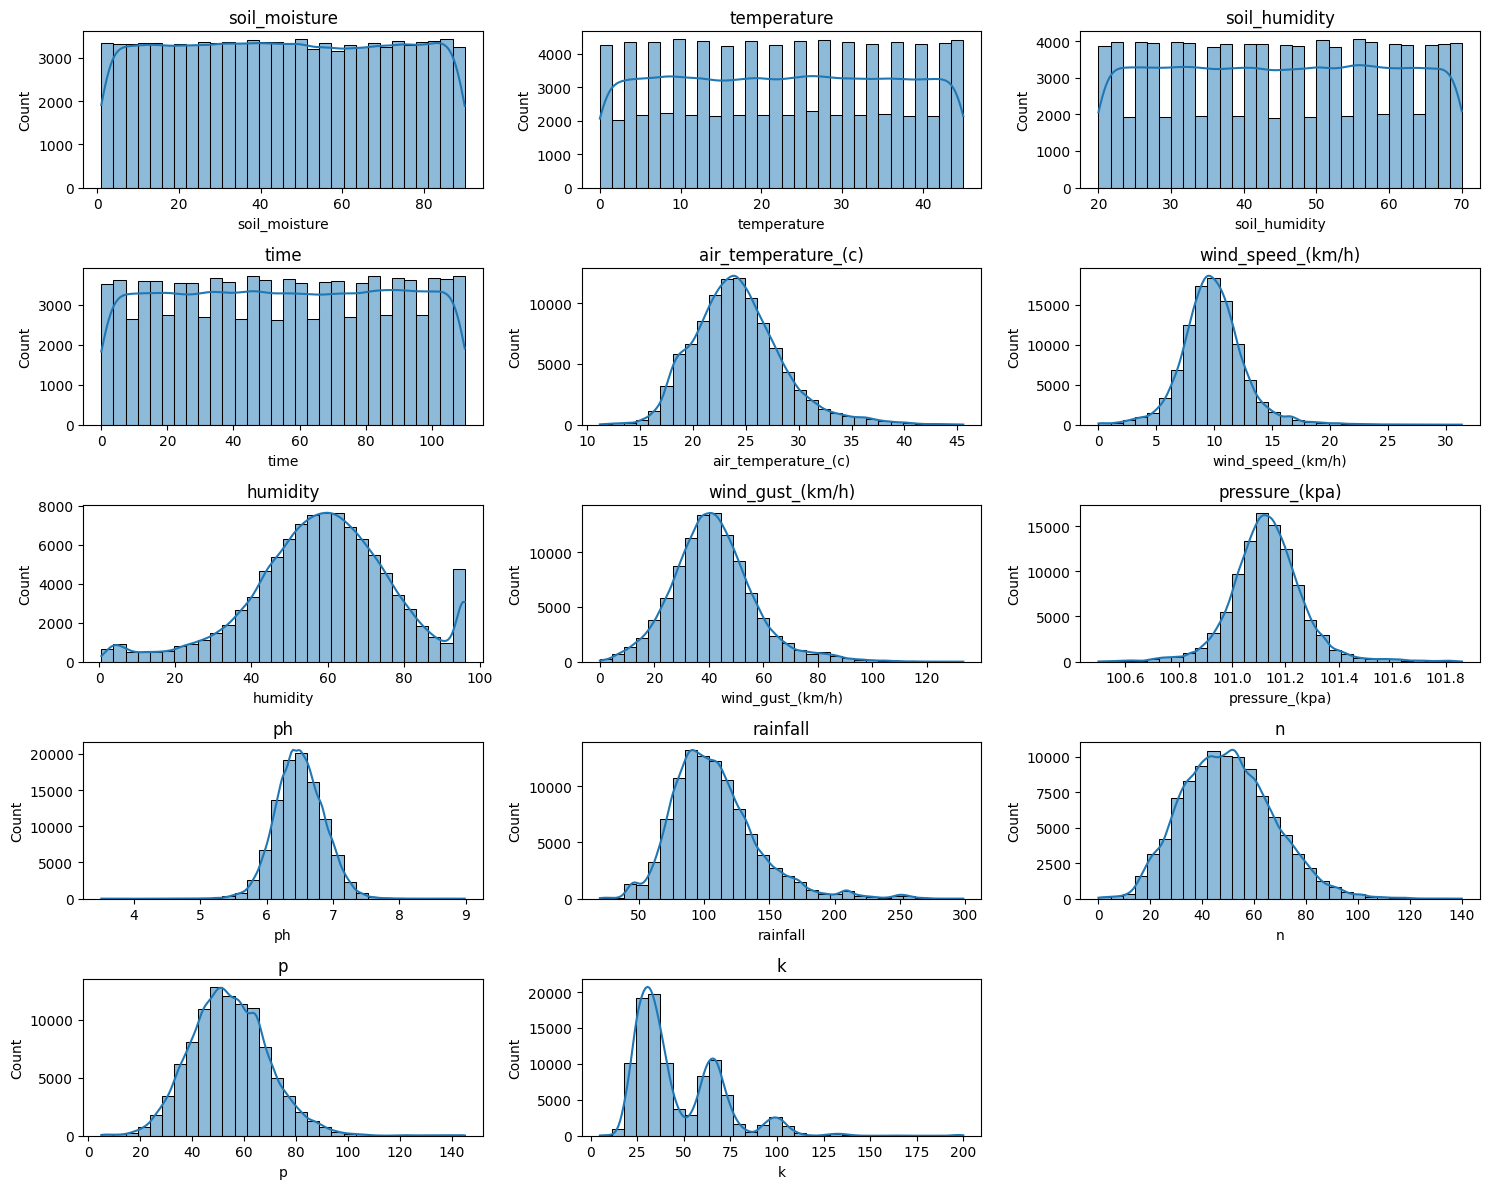

In [ ]:
num_cols = merged_df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(merged_df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

## Data Preperation

## Feature Engineering

In [ ]:
merged_df['soil_moisture_diff'] = merged_df.groupby('crop')['soil_moisture'].diff()

In [ ]:
numeric_cols = ['time','soil_moisture','temperature','soil_humidity',
                'air_temperature_(c)','wind_speed_(km/h)','humidity',
                'wind_gust_(km/h)','pressure_(kpa)','ph','rainfall','n','p','k']
merged_df[numeric_cols] = merged_df[numeric_cols].astype(float)

In [ ]:
# Encode crop and status
merged_df['status'] = merged_df['status'].map({'ON': 1, 'OFF': 0})

In [ ]:
merged_df['Relative_Soil_Saturation'] = merged_df['soil_moisture']/merged_df['soil_humidity']

In [ ]:
merged_df['temp_diff'] = merged_df['air_temperature_(c)'] - merged_df['temperature'] # Show evapuration

In [ ]:
merged_df['wind_effect'] = merged_df['wind_speed_(km/h)'] * merged_df['wind_gust_(km/h)'] # water loss with evapuration

In [ ]:
merged_df['Evapotranspiration'] = merged_df['humidity'] * merged_df['temperature'] # evaporation rate

In [ ]:
merged_df['rain_3days'] = merged_df['rainfall'].rolling(3).sum()

In [ ]:
merged_df['rain_vs_soil'] = merged_df['rainfall'] - merged_df['soil_moisture'] # show decrease or increse of water

In [ ]:
merged_df['np_ratio'] = merged_df['n'] / (merged_df['p'] + 1e-5) # NPK Ratio
merged_df['nk_ratio'] = merged_df['n'] / (merged_df['k'] + 1e-5)

In [ ]:
def categorize_ph(value): # PH categorization
    if value < 6.5:
        return 'Acidic'
    elif value <= 7.5:
        return 'Neutral'
    else:
        return 'Alkaline'

merged_df['ph_category'] = merged_df['ph'].apply(categorize_ph)


In [ ]:
merged_df['ph_encoded'] = merged_df['ph_category'].map({ # PH encoding
    'Acidic': 0,
    'Neutral': 1,
    'Alkaline': 2
})

In [ ]:
merged_df.head()

,soil_moisture,temperature,soil_humidity,time,air_temperature_(c),wind_speed_(km/h),humidity,wind_gust_(km/h),pressure_(kpa),ph,...,Relative_Soil_Saturation,temp_diff,wind_effect,Evapotranspiration,rain_3days,rain_vs_soil,np_ratio,nk_ratio,ph_category,ph_encoded
0,54.0,22.0,70.0,21.0,19.52,2.13,55.04,6.30,101.50,6.502985,...,0.771429,-2.48,13.4190,1210.88,NaN,148.935536,2.142857,2.093023,Neutral,1
1,12.0,20.0,40.0,104.0,19.49,2.01,55.17,10.46,101.50,7.038096,...,0.300000,-0.51,21.0246,1103.40,NaN,214.655537,1.465517,2.073170,Neutral,1
2,34.0,26.0,35.0,62.0,19.47,1.90,55.30,14.63,101.51,7.840207,...,0.971429,-6.53,27.7970,1437.80,693.555321,229.964248,1.090909,1.363636,Alkaline,2
3,7.0,44.0,44.0,93.0,19.54,2.28,54.20,16.08,101.51,6.980401,...,0.159091,-24.46,36.6624,2384.80,733.483819,235.864034,2.114285,1.850000,Neutral,1
4,50.0,38.0,23.0,92.0,19.61,2.66,53.09,17.52,101.51,7.628473,...,2.173913,-18.39,46.6032,2017.42,769.545622,212.717340,1.857142,1.857142,Alkaline,2


## Show the correlations

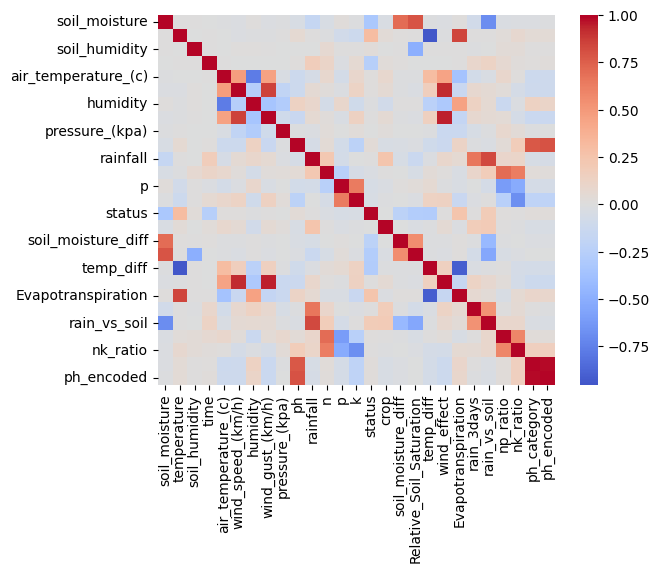

In [ ]:

le = LabelEncoder()
for col in merged_df.select_dtypes(include=['object']).columns:
    merged_df[col] = le.fit_transform(merged_df[col])
sns.heatmap(merged_df.corr(), cmap='coolwarm', center=0)
plt.show()


In [ ]:
corr_matrix = merged_df.corr(numeric_only=True)

print(corr_matrix)


print("\nTop correlations with 'status':")
print(corr_matrix['status'].sort_values(ascending=False))


                          soil_moisture  temperature  soil_humidity      time  \
soil_moisture                  1.000000     0.003622       0.003141 -0.001903   
temperature                    0.003622     1.000000      -0.002637  0.004481   
soil_humidity                  0.003141    -0.002637       1.000000  0.007086   
time                          -0.001903     0.004481       0.007086  1.000000   
air_temperature_(c)           -0.013077    -0.000964      -0.004778  0.006505   
wind_speed_(km/h)             -0.019005    -0.017059       0.014003 -0.001810   
humidity                       0.011562    -0.007149       0.009897 -0.000283   
wind_gust_(km/h)              -0.017277    -0.014209       0.002742 -0.004180   
pressure_(kpa)                -0.008136     0.002658      -0.004748  0.000027   
ph                            -0.037860     0.059866      -0.004308  0.008603   
rainfall                      -0.167493     0.005722      -0.005330  0.171098   
n                           

In [ ]:
merged_df['crop_encoded'] = merged_df.groupby('crop')['status'].transform('mean') # the crops encodes 0 to 1 value respect to water need

In [ ]:
merged_df['crop_encoded'].head()

,crop_encoded
0,0.569876
1,0.472449
2,0.472449
3,0.472449
4,0.472449


In [ ]:
merged_df.isna().sum()

,0
soil_moisture,0
temperature,0
soil_humidity,0
time,0
air_temperature_(c),0
wind_speed_(km/h),0
humidity,0
wind_gust_(km/h),0
pressure_(kpa),0
ph,0


In [ ]:
merged_df['soil_moisture_diff'] = merged_df['soil_moisture_diff'].fillna(0)

In [ ]:
merged_df['rain_3days'] = merged_df['rain_3days'].fillna(0)

In [ ]:
merged_df.isna().sum()

,0
soil_moisture,0
temperature,0
soil_humidity,0
time,0
air_temperature_(c),0
wind_speed_(km/h),0
humidity,0
wind_gust_(km/h),0
pressure_(kpa),0
ph,0


In [ ]:
#merged_df.to_csv("Final_irregation_optimization_data.csv", index=False)

In [ ]:
important_features = [
    'soil_moisture', 'temp_diff', 'Relative_Soil_Saturation',
    'soil_moisture_diff', 'temperature', 'Evapotranspiration',
    'rain_vs_soil', 'crop_encoded'
]

X = merged_df[important_features]
y = merged_df['status']

## Start modiling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistice regression model

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.69545

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.66      9305
           1       0.70      0.74      0.72     10695

    accuracy                           0.70     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.70      0.69     20000



## Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.75405

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      9305
           1       0.75      0.80      0.78     10695

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000


Confusion Matrix:
[[6517 2788]
 [2131 8564]]


## Model with Dummies

# Dummies and data spliting

In [ ]:
df_dummies = merged_df.copy()

df_dummies = pd.get_dummies(df_dummies, columns=['crop'], drop_first=True)

important_features = [
    'soil_moisture', 'temp_diff', 'Relative_Soil_Saturation',
    'soil_moisture_diff', 'temperature', 'Evapotranspiration',
    'rain_vs_soil'
] + [col for col in df_dummies.columns if col.startswith('crop_')]

In [ ]:
X = df_dummies[important_features]
y = df_dummies['status']

X = X.fillna(X.mean())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Reg

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.69465

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.64      0.66      9305
           1       0.70      0.74      0.72     10695

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000



# Random forest

In [ ]:
model = RandomForestClassifier(
    n_estimators=400,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.75500

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      9305
           1       0.75      0.81      0.78     10695

    accuracy                           0.76     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.76      0.76      0.75     20000


Confusion Matrix:
[[6458 2847]
 [2053 8642]]



Confusion Matrix:


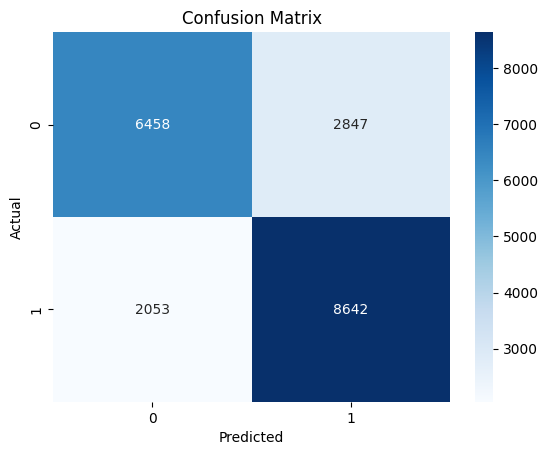

In [ ]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Top 10 Important Features:
soil_moisture               0.177342
Relative_Soil_Saturation    0.167695
rain_vs_soil                0.149998
temp_diff                   0.144633
Evapotranspiration          0.136759
temperature                 0.118923
soil_moisture_diff          0.104650
dtype: float64


/tmp/ipython-input-3184466146.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index, palette="viridis")


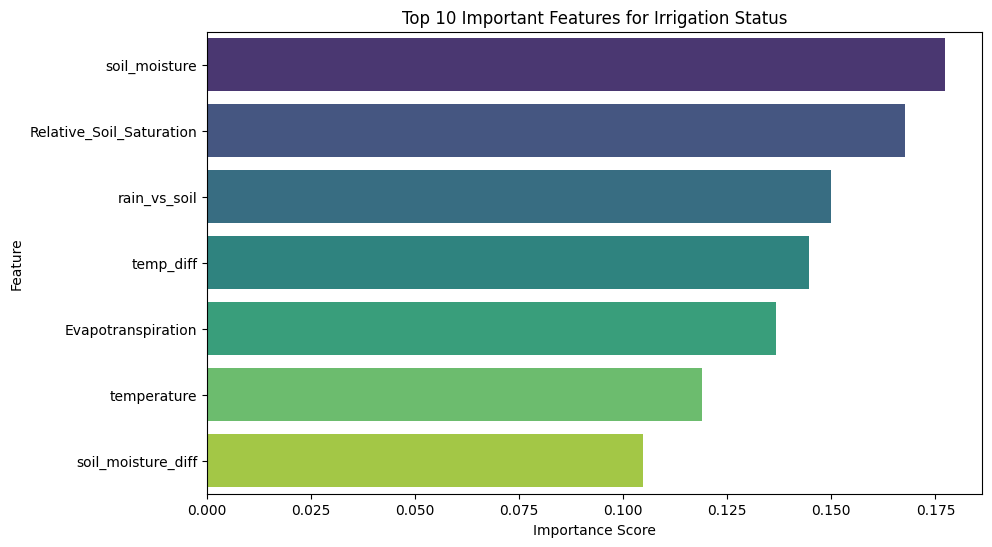

In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 Important Features:")
print(feature_importances.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index, palette="viridis")
plt.title("Top 10 Important Features for Irrigation Status")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Add some Feautures

In [ ]:
merged_df['moisture_temp_ratio'] = merged_df['soil_moisture'] / (merged_df['temperature'] + 1)
merged_df['evapo_ratio'] = merged_df['Evapotranspiration'] / (merged_df['Relative_Soil_Saturation'] + 1)
merged_df['rain_effect'] = merged_df['rain_vs_soil'] * merged_df['rainfall']
merged_df['moisture_change_rate'] = merged_df['soil_moisture_diff'] / (merged_df['soil_moisture'] + 1)
merged_df['temp_scaled'] = merged_df['temp_diff'] / (merged_df['temperature'] + 1)
merged_df['npk_balance'] = (merged_df['n'] + merged_df['p'] + merged_df['k']) / 3
merged_df['wind_ratio'] = merged_df['wind_speed_(km/h)'] / (merged_df['wind_gust_(km/h)'] + 1)

In [ ]:
important_features = [
    'soil_moisture', 'temperature', 'soil_humidity', 'Relative_Soil_Saturation',
    'temp_diff', 'Evapotranspiration', 'rain_vs_soil', 'rainfall', 'ph_encoded',
    'n', 'p', 'k', 'np_ratio', 'nk_ratio', 'crop_encoded', 'rain_3days',
    'moisture_temp_ratio', 'evapo_ratio', 'rain_effect', 'moisture_change_rate',
    'temp_scaled', 'npk_balance', 'wind_ratio'
]

X = merged_df[important_features]
y = merged_df['status']

X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgbm = LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.01,
    num_leaves=40,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.4,
    class_weight='balanced',
    random_state=42
)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 42955, number of negative: 37045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4804
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Accuracy: 0.7976

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78      9305
           1       0.80      0.83      0.81     10695

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



In [ ]:
cat = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.02,
    depth=10,
    l2_leaf_reg=5,
    random_strength=1.5,
    bagging_temperature=0.8,
    border_count=128,
    verbose=False,
    random_seed=42
)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8471
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      9305
           1       0.84      0.88      0.86     10695

    accuracy                           0.85     20000
   macro avg       0.85      0.84      0.85     20000
weighted avg       0.85      0.85      0.85     20000



In [ ]:
!pip install optuna catboost -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
import optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 256),
        'verbose': False,
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    return acc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("🎯 Best Accuracy:", study.best_value)
print("🏆 Best Parameters:", study.best_params)

[I 2025-10-07 13:10:22,475] A new study created in memory with name: no-name-65453c16-b832-4e79-b480-c64c0230fdcd
[I 2025-10-07 13:11:39,596] Trial 0 finished with value: 0.80835 and parameters: {'iterations': 1331, 'learning_rate': 0.014274106754002234, 'depth': 8, 'l2_leaf_reg': 3.4332859996682856, 'random_strength': 1.540475250924325, 'bagging_temperature': 0.930669597554342, 'border_count': 156}. Best is trial 0 with value: 0.80835.
[I 2025-10-07 13:15:45,024] Trial 1 finished with value: 0.86665 and parameters: {'iterations': 2650, 'learning_rate': 0.02636837067946103, 'depth': 10, 'l2_leaf_reg': 1.9873024684472678, 'random_strength': 0.707537266112783, 'bagging_temperature': 0.9416550070767586, 'border_count': 83}. Best is trial 1 with value: 0.86665.
[I 2025-10-07 13:16:17,836] Trial 2 finished with value: 0.7579 and parameters: {'iterations': 1338, 'learning_rate': 0.008259023940589142, 'depth': 5, 'l2_leaf_reg': 8.245447277814563, 'random_strength': 0.883203869967824, 'bagging

🎯 Best Accuracy: 0.8738
🏆 Best Parameters: {'iterations': 2999, 'learning_rate': 0.03678699532723989, 'depth': 11, 'l2_leaf_reg': 5.659066647532403, 'random_strength': 1.767805749411203, 'bagging_temperature': 0.8833853074316629, 'border_count': 172}


In [ ]:
best_params = study.best_params

best_params['verbose'] = False
best_params['random_seed'] = 42

best_cat = CatBoostClassifier(**best_params)
best_cat.fit(X_train, y_train)

y_pred = best_cat.predict(X_test)
print("✅ Final Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ Final Accuracy: 0.8738
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      9305
           1       0.87      0.90      0.88     10695

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000



In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_cat.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance.head(10))


                     Feature  Importance
2              soil_humidity   14.310028
0              soil_moisture    8.699291
1                temperature    7.094101
10                         p    6.297137
11                         k    5.875199
16       moisture_temp_ratio    5.551749
7                   rainfall    5.208675
3   Relative_Soil_Saturation    4.877254
8                 ph_encoded    4.347471
9                          n    4.338942


## Reporting

In [ ]:
y_pred = best_cat.predict(X_test)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df.to_csv("model_report.csv", index=True)
with open("model_accuracy.txt", "w") as f:
    f.write(f"Final Accuracy: {acc:.4f}\n")

print("✅ Accuracy and report saved successfully!")

✅ Accuracy and report saved successfully!


In [ ]:
joblib.dump(best_cat, "catboost_model.pkl")

['catboost_model.pkl']

In [ ]:
# Save
with open("best_params.json", "w") as f:
    json.dump(study.best_params, f)

# open
#with open("best_params.json", "r") as f:
#    best_params = json.load(f)
